In [1]:
#Utilities + data handling
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

#Arima 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

Using ARIMA model to predict the return of a stock from March 2nd 2019 up to now. The training dataset's size is up to you. Note that the daily return of the stock (not the stock price) is the objective of this model. 


### Getting data
1. I will use google stock
2. I we have to predict 2 years of stock data, I will select two years worth of data for training, so March 3, 2017 will be the first date for which I have stock data.

In [3]:
data = pd.DataFrame(pdr.get_data_yahoo('GOOGL','2017-03-02','2021-03-02').to_records())

data.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-03-02,856.489990,848.719971,856.309998,849.849976,1250900,849.849976
1,2017-03-03,850.820007,844.710022,848.940002,849.080017,1005000,849.080017
2,2017-03-06,848.940002,841.169983,846.859985,847.270020,1047900,847.270020
3,2017-03-07,853.330017,845.520020,847.260010,851.150024,1038700,851.150024
4,2017-03-08,856.929993,851.250000,853.119995,853.640015,1028800,853.640015


In [4]:
#Compute daily returns
#We works with logs for numerical stability
return_data = pd.DataFrame({'Close': np.log(data['Adj Close'] / data['Adj Close'].shift(1)).values}, 
                           index=data.Date.values)

return_data = return_data.dropna() #Drop first observation, as the change is undefined for it
return_data.head()

,Close
2017-03-03,-0.000906
2017-03-06,-0.002134
2017-03-07,0.004569
2017-03-08,0.002921
2017-03-09,0.004908


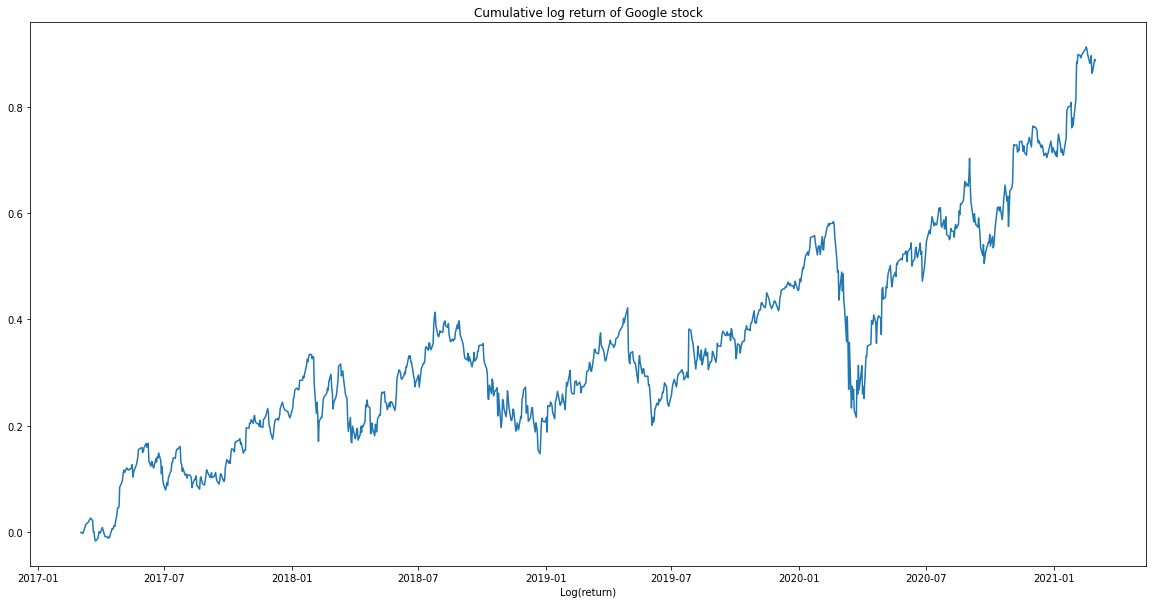

In [15]:
plt.figure(figsize=(20, 10))
plt.plot(return_data.index, np.cumsum(return_data['Close']))
plt.title('Cumulative log return of Google stock');
plt.xlabel('Log(return)')

# Fitting ARIMA to the stock price training data
1. Use seasonal_decompose class to decompose the time series and use the plot() function of this class to visualize the result
2. Use auto_arima to find the best setting given time series data, then .summary() function to observe the setting
3. Use ARIMA to train the model with the best setting you’ve found. And using this setting to predict the return in the future.
4. Visualize the prediction and actual returns on the same graph
5. Assess prediction using some metrics such as MSE, MAE, RMSE, MAPE

After finishing the coding work, answer the following questions

- How good is your prediction?
- Are there any better metrics better than the suggested ones, especially when ARIMA is used for trading purposes?

In [17]:
# Splitting the data into train and test 

train = return_data[:"2019-03-03"]
test = return_data["2019-03-03":]

<Figure size 432x288 with 0 Axes>

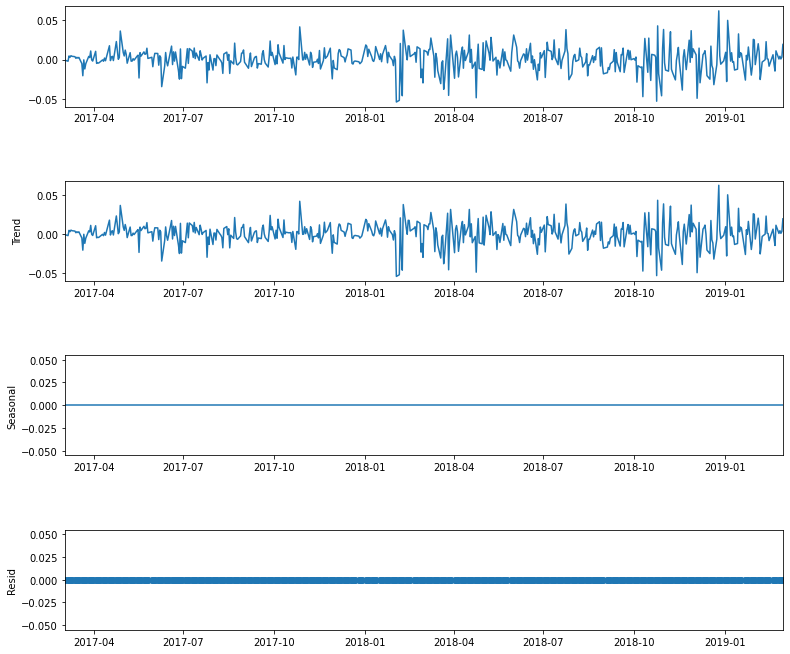

In [18]:
# 1. Using seasonal decompose function
decompose = seasonal_decompose(train, period=1)
fig = plt.figure()
fig = decompose.plot()
fig.set_size_inches(12, 10)

In [19]:
#Fitting ARIMA, using auto_arima
model = auto_arima(train) # perform model search on train data
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  502
Model:               SARIMAX(2, 0, 2)   Log Likelihood                1408.332
Date:                Mon, 08 Mar 2021   AIC                          -2804.665
Time:                        07:55:16   BIC                          -2779.353
Sample:                             0   HQIC                         -2794.734
                                - 502                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0015      0.002      0.916      0.360      -0.002       0.005
ar.L1         -0.6873      0.092     -7.491      0.000      -0.867      -0.507
ar.L2         -0.8301      0.098     -8.438      0.0

In [22]:
# 3. Use best model parameters from training, to make predictions for the test_set
predicted_returns = model.predict(n_periods=test.shape[0])

In [24]:
test["predicted_returns"] = predicted_returns

<ipython-input-24-b6d5672a77ff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predicted_returns"] = predicted_returns


Text(0.5, 0, 'Log(return)')

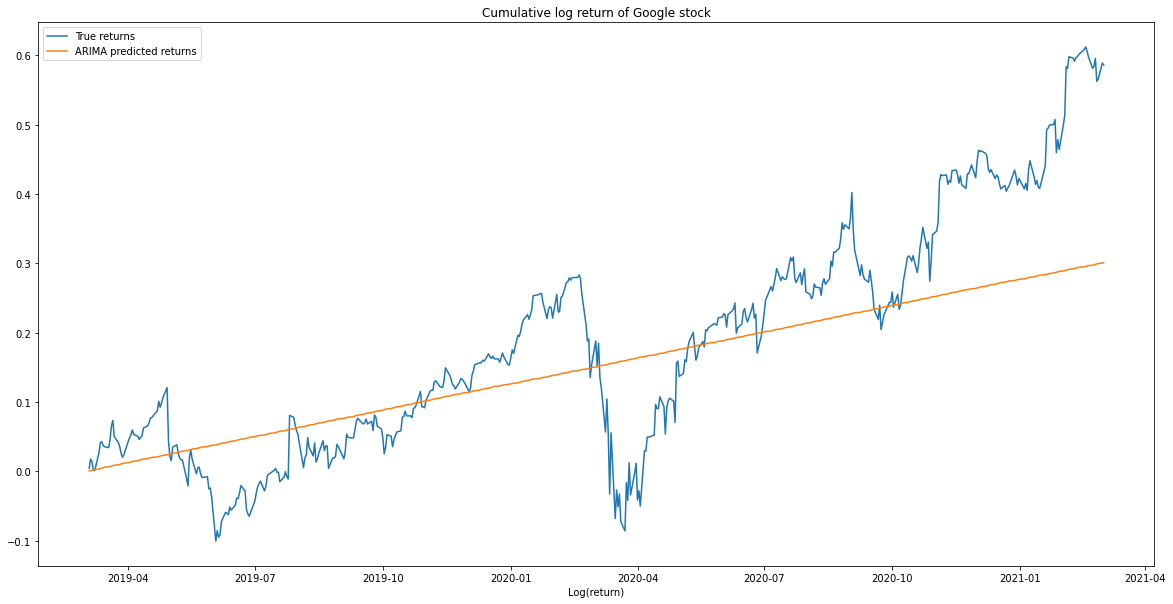

In [27]:
#4. Visualizing forecasts vs. actual returns

plt.figure(figsize=(20, 10))
plt.plot(test.index, np.cumsum(test['Close']), label = "True returns")
plt.plot(test.index, np.cumsum(test['predicted_returns']), label = "ARIMA predicted returns")
plt.legend(loc=0)
plt.title('Cumulative log return of Google stock')
plt.xlabel('Log(return)')

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [31]:
#Just to see order of magnitude of average daily log returns,
#So we can interpret the error statistics
test["Close"].mean()

0.0011635003873839771

In [30]:
#MAE
mean_absolute_error(test["Close"], test["predicted_returns"])

#Note this is an order of magnitude greater than the mean returns -> large error

0.013573720164747678

In [32]:
#MSE
mean_squared_error(test["Close"], test["predicted_returns"])

0.0004206608973610765

Difference between these two numbers is explained by the average log daily returns being quite 10^-3, meaning that squares become very small.

In general, however, as is evident from the plot as well as the error metrics, this is not by any means an extraordinary prediction. It seems it has, in effect, extrapolated the trainingset trend into the test period, with very minimal variance–essentially just a straight line. That said, predicting stock price movement two years into the future is practically an impossible task, for any model–we should thus not consider this result evidence of ARIMA not working well.

If we would want to implement a trading strategy based on the ARIMA model, we would have to employ trading specific metrics to evaluate its performance. For example, we'd want to look at drawdown statistics, sharpe ratio and some measure of returns.